# Get imports

In [11]:
import os
import pickle
import random
import copy

import librosa
import mirdata
import openl3
import numpy as np
import tensorflow as tf
import sklearn
import pandas as pd
from IPython.display import display, Audio

from tqdm import tqdm


## Set initial constants

In [12]:
MIRDATA_MDSB_PATH = './mirdatasets/medley_solos_db'
SR = 48000

## Get data

In [13]:
msdb = mirdata.initialize('medley_solos_db', data_home=MIRDATA_MDSB_PATH)
#msdb.download()

## Inspect data

In [14]:
track = msdb.choice_track()
x, fs = librosa.load(track.audio_path, sr=SR)
display(Audio(x, rate=fs))
x.shape[0] / SR

2.972166666666667

### Check data distribution (training set)

In [15]:
# JUST COPY AND PASTE THIS ONE
def get_instrument_counts(subset='training'):
    msdb = mirdata.initialize('medley_solos_db', data_home=MIRDATA_MDSB_PATH)
    
    inst_df = pd.DataFrame.from_records([dict(instrument_id=msdb.track(track_id).instrument_id,
                                              instrument=str(msdb.track(track_id).instrument_id) + ' ' +
                                              msdb.track(track_id).instrument) for track_id in msdb.track_ids
                                         if msdb.track(track_id).subset==subset])
    
    return inst_df

In [16]:
inst_df = get_instrument_counts()

<AxesSubplot:ylabel='instrument'>

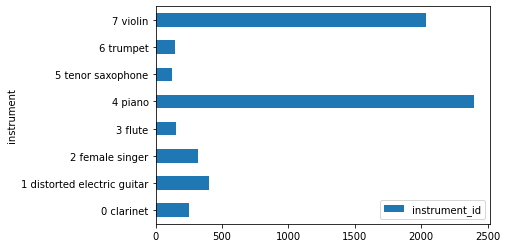

In [17]:
inst_df.groupby('instrument').count().plot.barh()

### Check data distribution (test set)

<AxesSubplot:ylabel='instrument'>

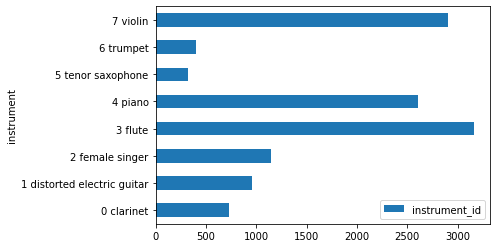

In [18]:
get_instrument_counts('test').groupby('instrument').count().plot.barh()

## Get class weights to help with class imbalance

In [19]:
NUM_CLASSES = 8

In [26]:
def get_class_weights(inst_df):
    class_weights = (1 / inst_df.groupby('instrument_id').count()) * (inst_df.shape[0] / NUM_CLASSES)
    return class_weights.to_dict()['instrument']

In [27]:
class_weights = get_class_weights(inst_df)

In [28]:
class_weights

{0: 2.9088645418326693,
 1: 1.807240099009901,
 2: 2.295990566037736,
 3: 4.710483870967742,
 4: 0.3040920449812578,
 5: 5.935975609756098,
 6: 4.900167785234899,
 7: 0.3579044117647059}

## Write data loader

In [13]:
# first we'll write a python generator
def msdb_generator(subset='training', limit=-1, data_home=MIRDATA_MDSB_PATH):
    msdb = mirdata.initialize('medley_solos_db', data_home=data_home)
    track_ids = [t_id for t_id in msdb.track_ids if msdb.track(t_id).subset==subset]
    track_ids = track_ids[:limit]
    
    random.shuffle(track_ids)
    
    for track_id in track_ids:
        track = msdb.track(track_id)
        audio, sr = librosa.load(track.audio_path, sr=SR)
        for x in librosa.util.frame(audio, frame_length=SR, hop_length=SR//2).T:
            yield x[np.newaxis,:].astype(np.float32), track.instrument_id

In [14]:
## check generator
g = msdb_generator()

In [15]:
next(g)

(array([[-0.00480923, -0.00688072, -0.00838492, ...,  0.00066404,
          0.00271915,  0.00470814]], dtype=float32),
 6)

## Build model

In [16]:
ol3 = openl3.models.load_audio_embedding_model(input_repr="mel256", content_type="music",
                                               embedding_size=512)

In [20]:
ol3.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 48000)]        0         
_________________________________________________________________
melspectrogram (Sequential)  (None, 256, 199, 1)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 199, 1)       4         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 199, 64)      640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 199, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 256, 199, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 199, 64)      3692

In [21]:
def build_model(ol3_trainable=False):
    """
    Build our model
    """
    ol3 = openl3.models.load_audio_embedding_model(input_repr="mel256", content_type="music",
                                                   embedding_size=512)
    ol3.trainable = ol3_trainable
        
    x_a = tf.keras.layers.Input(shape=(1,SR))
    y_a = ol3(x_a)
        
    y_a = tf.keras.layers.Dense(units=NUM_CLASSES, activation="softmax",)(y_a)
    model = tf.keras.Model(inputs=x_a, outputs=y_a)

    return model

In [22]:
model = build_model()

In [23]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1, 48000)]        0         
_________________________________________________________________
model_6 (Model)              (None, 512)               4689860   
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4104      
Total params: 4,693,964
Trainable params: 4,104
Non-trainable params: 4,689,860
_________________________________________________________________


## Write training function

In [1]:
MODEL_PATH = '<PUT_YOUR_PATH_HERE>'

In [28]:
def train_model(config, model=None, model_chkpt_path=MODEL_PATH):     
    # setup data 
    msdb_training_dataset = tf.data.Dataset.from_generator(lambda: msdb_generator(subset='training',
                                                                                  limit=config['training_set_limit']),
                                                           output_types=(tf.float32, tf.int32),
                                                           output_shapes=((1,SR), ()))

    msdb_training_dataset = msdb_training_dataset.shuffle(buffer_size=config['buffer_size']).repeat().batch(config['batch_size'])
    
    msdb_validation_dataset = tf.data.Dataset.from_generator(lambda: msdb_generator(subset='validation',
                                                                                    limit=config['validation_set_limit']),
                                                             output_types=(tf.float32, tf.int32),
                                                             output_shapes=((1,SR), ()))

    msdb_validation_dataset = msdb_validation_dataset.batch(config['batch_size']).prefetch(tf.data.experimental.AUTOTUNE)
    
    # compute class weights from training set
    inst_df = get_instrument_counts()
    class_weights = get_class_weights(inst_df)
    
    # build and compile model
    if model is None:
        model = build_model()
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    print(model.summary())
    
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
                     filepath=model_chkpt_path,
                     save_weights_only=True,
                     monitor='val_accuracy',
                     mode='max',
                     save_best_only=True),]
    
    history = model.fit(msdb_training_dataset, 
                        batch_size=config['batch_size'],
                        epochs=config['epochs'],
                        steps_per_epoch=config['steps_per_epoch'],
                        validation_data=msdb_validation_dataset,
                        callbacks=callbacks,
                        class_weight=class_weights)

    
    return model, history